In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Imports

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

Pandas Settings:

In [3]:
pd.set_option("max_colwidth", 150)
pd.set_option("display.max_columns", 60)
pd.set_option('max_rows', None)
# pd.set_option("max_colwidth", 250)

Okay heres the order for the MVP training set:
1. Drop non-MVP columns
1. Drop NaN values
1. OHC Sex column
1. Split X and Y
1. Fit
1. Score

## Importing Datasets

In [4]:
df_train = pd.read_csv(r'C:\Users\ggomp\OneDrive\Documents\GitHub\Kaggle_Competitions\titanic_classification\datasets\train.csv')
df_test = pd.read_csv(r'C:\Users\ggomp\OneDrive\Documents\GitHub\Kaggle_Competitions\titanic_classification\datasets\test.csv')
df_sub = pd.read_csv(r'C:\Users\ggomp\OneDrive\Documents\GitHub\Kaggle_Competitions\titanic_classification\datasets\gender_submission.csv')

display(df_train.head(2))
display(df_test.tail(2))
display(df_sub.head(2))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


,PassengerId,Survived
0,892,0
1,893,1


1. Drop non-MVP columns from both train and test sets

In [5]:
train_copy = df_train.copy()
train_mvp = train_copy.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)
display(train_mvp.head(2))

test_copy = df_test.copy()
test_mvp = test_copy.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)
display(test_mvp.tail(2))

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
416,3,male,NaN,0,0,8.0500,S
417,3,male,NaN,1,1,22.3583,C


Checking for NaN values

In [6]:
# print("df_train:\n", df_train.isnull().sum())
print('train set:')
print(train_mvp.isnull().sum())

print()
print('test set:')
print(test_mvp.isnull().sum())

# print(train_mvp['Embarked'].isnull())

train set:
Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

test set:
Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64


3. OHC 2 Columns

In [7]:
#train set
print('train set')
train_mvp_c = train_mvp.copy()
train_mvp_c = pd.get_dummies(train_mvp_c,prefix=['Sex'], columns = ['Sex'], drop_first=True)
train_mvp_c = pd.get_dummies(train_mvp_c,prefix=['Embarked'], columns = ['Embarked'], drop_first=True)

display(train_mvp_c.head(2))
print(train_mvp_c.isnull().sum())
print('\n\n')
# display(train_mvp_c.iloc[59:64])

# test set
print('test set')
test_mvp_c = test_mvp.copy()
test_mvp_c = pd.get_dummies(test_mvp_c,prefix=['Sex'], columns = ['Sex'], drop_first=True)
test_mvp_c = pd.get_dummies(test_mvp_c,prefix=['Embarked'], columns = ['Embarked'], drop_first=True)

display(test_mvp_c.tail(2))
print(test_mvp_c.isnull().sum())


train set


,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0


Survived        0
Pclass          0
Age           177
SibSp           0
Parch           0
Fare            0
Sex_male        0
Embarked_Q      0
Embarked_S      0
dtype: int64



test set


,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
416,3,NaN,0,0,8.0500,1,0,1
417,3,NaN,1,1,22.3583,1,0,0


Pclass         0
Age           86
SibSp          0
Parch          0
Fare           1
Sex_male       0
Embarked_Q     0
Embarked_S     0
dtype: int64


2. Imputting NaN values

In [8]:
imputer = IterativeImputer()
# imputer = KNNImputer(n_neighbors=8)

# Train Set
print("Train Set")
train_mvp_c = imputer.fit_transform(train_mvp_c)
train_mvp_c = pd.DataFrame(train_mvp_c)
display(train_mvp_c.tail(3))
print(train_mvp_c.isnull().sum())
print('\n')
# train_mvp_c = train_mvp_c.reindex_like(train_mvp)
# columns = ['Survived', Pclass]

#Test Set
print('Test Set')
test_mvp_c = imputer.fit_transform(test_mvp_c)
test_mvp_c = pd.DataFrame(test_mvp_c)
display(test_mvp_c.tail(3))
print(test_mvp_c.isnull().sum())

Train Set


,0,1,2,3,4,5,6,7,8
888,0.0,3.0,23.190155,1.0,2.0,23.45,0.0,0.0,1.0
889,1.0,1.0,26.000000,0.0,0.0,30.00,1.0,0.0,0.0
890,0.0,3.0,32.000000,0.0,0.0,7.75,1.0,1.0,0.0


0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
dtype: int64


Test Set


,0,1,2,3,4,5,6,7
415,3.0,38.500000,0.0,0.0,7.2500,1.0,0.0,1.0
416,3.0,24.941183,0.0,0.0,8.0500,1.0,0.0,1.0
417,3.0,23.236983,1.0,1.0,22.3583,1.0,0.0,0.0


0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
dtype: int64


2. Drop NaN values


In [9]:
train_mvp_c = train_mvp_c.dropna(axis = 0)
train_mvp_c = train_mvp_c.reset_index(drop=True)
display(train_mvp_c.tail(5))

test_mvp_c = test_mvp_c.dropna(axis = 0)
test_mvp_c = test_mvp_c.reset_index(drop=True)
display(test_mvp_c.tail(5))


,0,1,2,3,4,5,6,7,8
886,0.0,2.0,27.000000,0.0,0.0,13.00,1.0,0.0,1.0
887,1.0,1.0,19.000000,0.0,0.0,30.00,0.0,0.0,1.0
888,0.0,3.0,23.190155,1.0,2.0,23.45,0.0,0.0,1.0
889,1.0,1.0,26.000000,0.0,0.0,30.00,1.0,0.0,0.0
890,0.0,3.0,32.000000,0.0,0.0,7.75,1.0,1.0,0.0


,0,1,2,3,4,5,6,7
413,3.0,24.941183,0.0,0.0,8.0500,1.0,0.0,1.0
414,1.0,39.000000,0.0,0.0,108.9000,0.0,0.0,0.0
415,3.0,38.500000,0.0,0.0,7.2500,1.0,0.0,1.0
416,3.0,24.941183,0.0,0.0,8.0500,1.0,0.0,1.0
417,3.0,23.236983,1.0,1.0,22.3583,1.0,0.0,0.0


3. Split X and Y

In [36]:
# Train Set
x_train, y_train = train_mvp_c.iloc[:,1:], train_mvp_c.iloc[:, 0]
display(x_train.tail(2))
display(y_train.tail(2))

,1,2,3,4,5,6,7,8
889,1.0,26.0,0.0,0.0,30.00,1.0,0.0,0.0
890,3.0,32.0,0.0,0.0,7.75,1.0,1.0,0.0


889    1.0
890    0.0
Name: 0, dtype: float64

## Exporting proccesed data to CSV

In [43]:
x_train.to_csv(r'.\proccesed_data\x_train.csv', index=False)
y_train.to_csv(r'.\proccesed_data\y_train.csv', index=False)
test_mvp_c.to_csv(r'.\proccesed_data\x_test.csv', index=False)

## Continue to Training Notebook

In [13]:
# Test options and evaluation metric 
scoring = 'f1'
kfold = KFold(n_splits=10, random_state=1, shuffle=True)

In [14]:
%%time

results = []
names = []
for name, model in models:
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))

AdaBoost: 0.745510 (0.046583)
KNN: 0.740052 (0.044793)
BagClass: 0.764324 (0.042943)
Bernouli: 0.690997 (0.045513)


C:\Users\ggomp\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\ggomp\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\ggomp\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\ggomp\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\ggomp\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

Calibrated: 0.739937 (0.049830)
DecisionT: 0.742154 (0.038619)
ExtraTrees: 0.756910 (0.052216)
GaussNB: 0.723320 (0.061146)
GBoostC: 0.767251 (0.057901)
LDA: 0.732410 (0.038429)
LogisticR: 0.739793 (0.049976)
MLP: 0.759220 (0.039471)
NuSVC: 0.750193 (0.060141)
PAC: 0.643724 (0.097183)
QDA: 0.735204 (0.059793)
RandomF: 0.767206 (0.044310)
RidgeC: 0.732042 (0.039895)
SGD: 0.675929 (0.059301)
SVC: 0.740011 (0.063087)
XGB: 0.769662 (0.046058)
Wall time: 17.2 s


Visual Comparison of Models

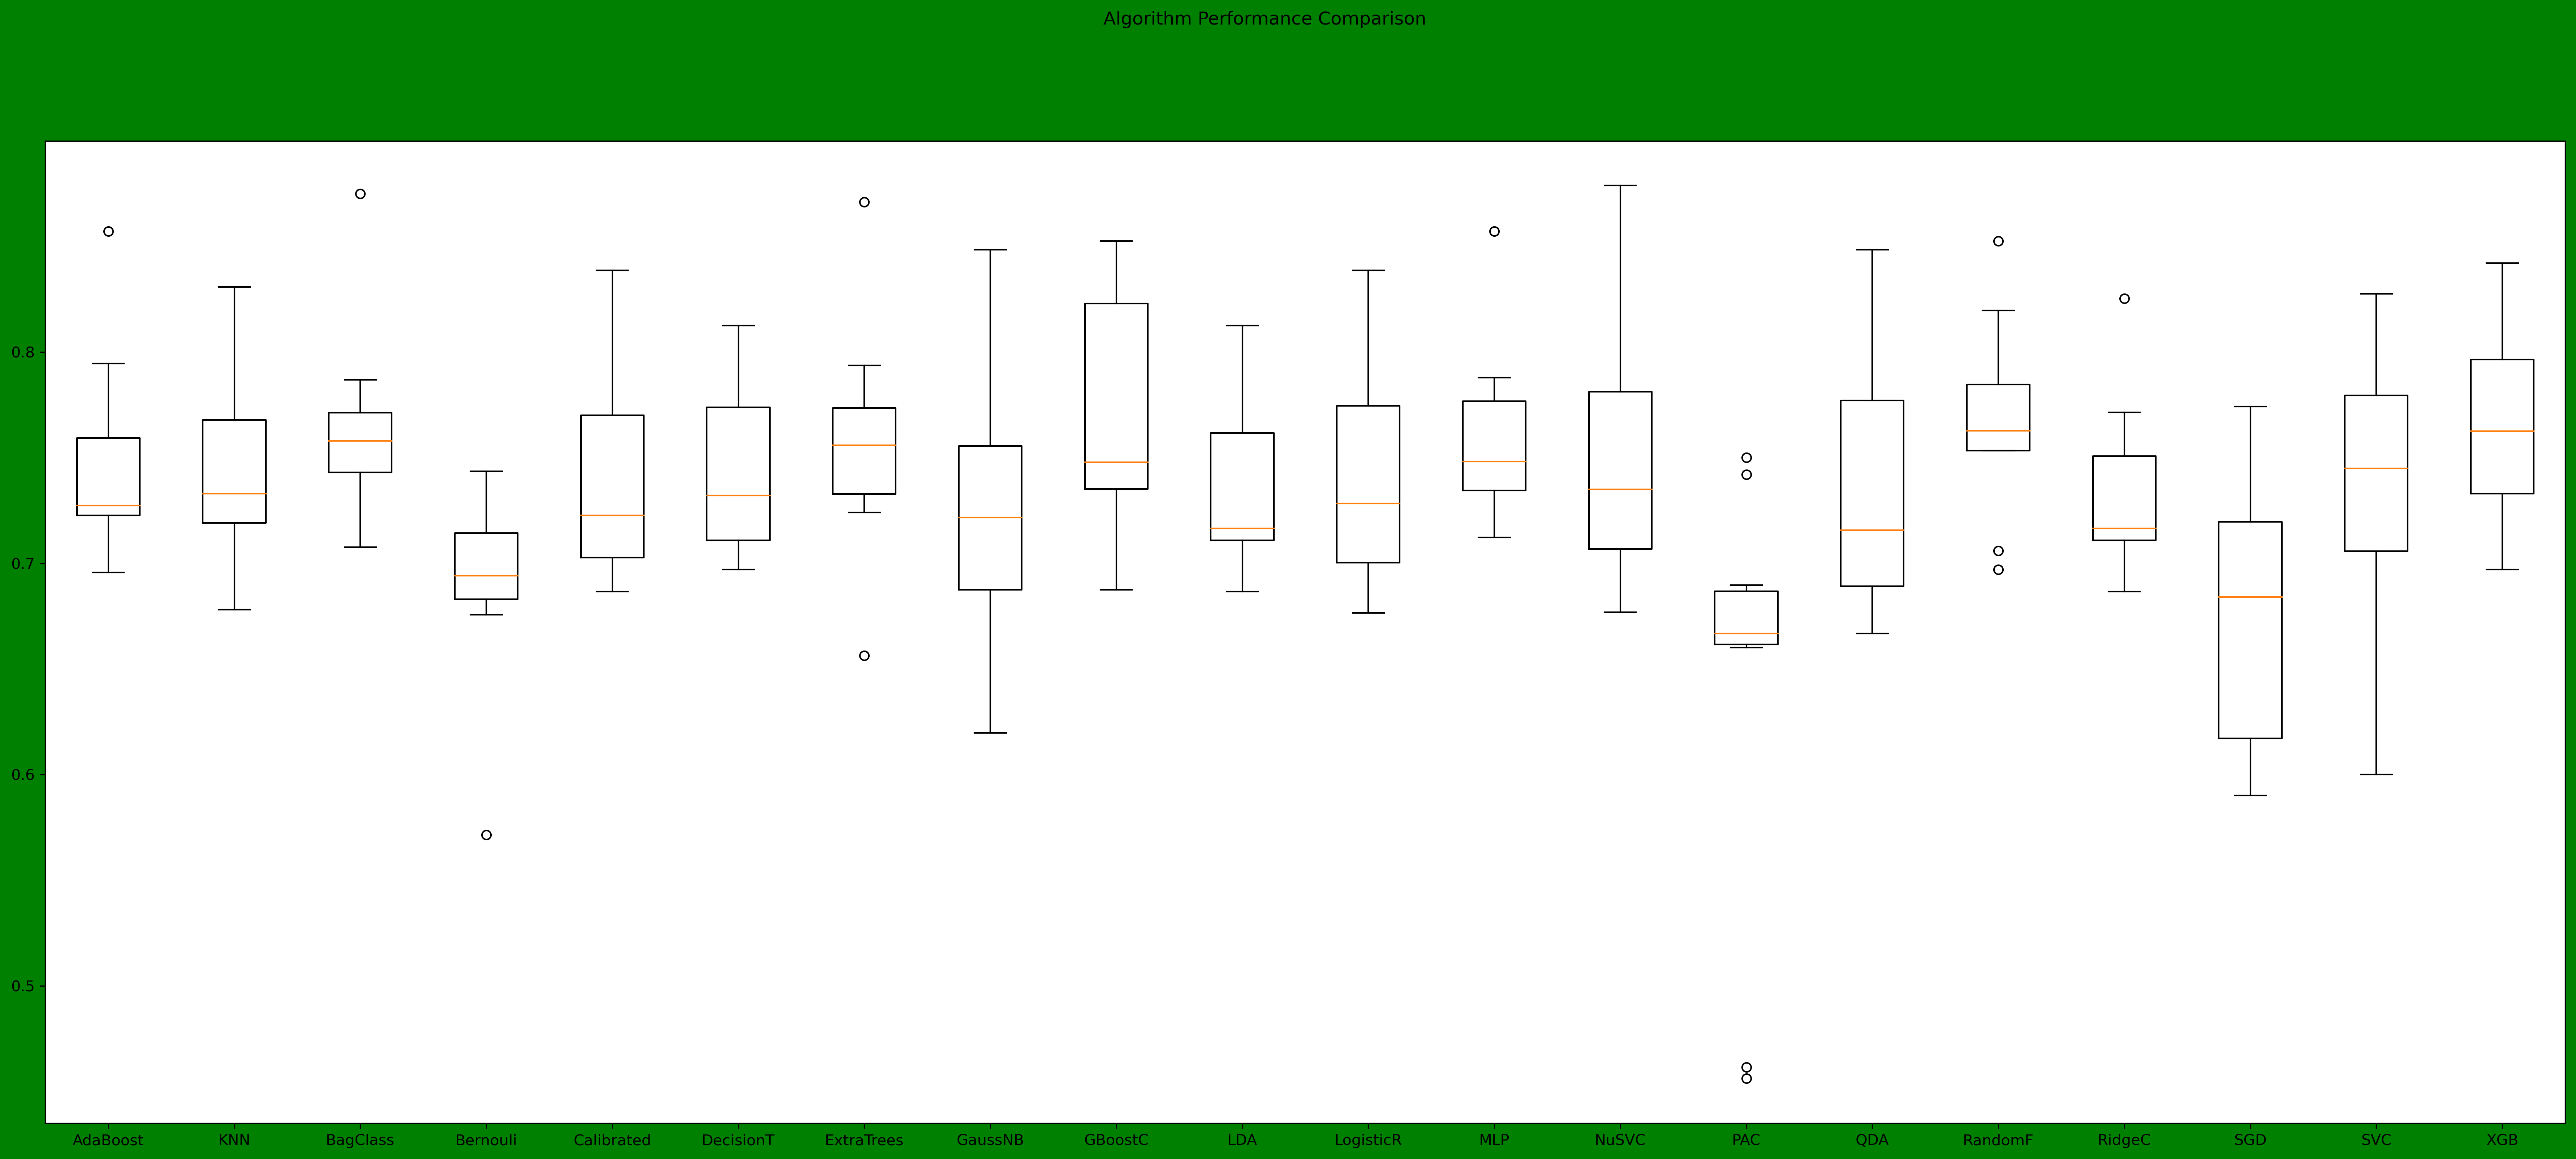

In [15]:
fig = plt.figure(figsize=(30,12), dpi= 300, facecolor='g', edgecolor='w')
fig.suptitle('Algorithm Performance Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Tuning top 3 Models

## KNN Tuning

In [16]:
#models[1][1].get_params()

In [18]:
%%time
model_knn = GridSearchCV(estimator = models[1][1], 
                         param_grid = {'model__n_neighbors': np.arange(6,15),
                                       'model__leaf_size': np.arange(1,50,5)},
                         cv=10)

model_knn.fit(X, Y)
print(f'highest mean cv score: {model_knn.best_score_}, with params: {model_knn.best_params_}')

highest mean cv score: 0.8316604244694131, with params: {'model__leaf_size': 1, 'model__n_neighbors': 10}
Wall time: 6.72 s


## Confusion Matrix for KNN

In [26]:
# display(test_mvp_c.head(3))
# df_preds = pd.DataFrame(model_knn.predict(test_mvp_c))
# df_preds = df_preds.astype(int)
# display(df_preds.tail(2))
# confusion_matrix(test_mvp_c, df_preds)

from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(model_knn, X, Y, cv=10)
print(confusion_matrix(Y, y_pred))

[[497  52]
 [101 241]]


## ROC Curve for KNN

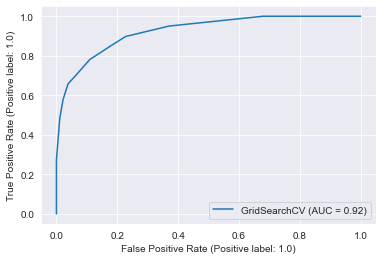

In [34]:
from sklearn import metrics, model_selection
metrics.plot_roc_curve(model_knn, X, Y)
import seaborn as sns
sns.set_style('darkgrid')
# plt.xlabel("True Positive Rate")

## Gradient Boosted Classifer Tuning

In [18]:
models[8][1].get_params()

{'memory': None,
 'steps': [('scaling', StandardScaler()),
  ('model', GradientBoostingClassifier())],
 'verbose': False,
 'scaling': StandardScaler(),
 'model': GradientBoostingClassifier(),
 'scaling__copy': True,
 'scaling__with_mean': True,
 'scaling__with_std': True,
 'model__ccp_alpha': 0.0,
 'model__criterion': 'friedman_mse',
 'model__init': None,
 'model__learning_rate': 0.1,
 'model__loss': 'deviance',
 'model__max_depth': 3,
 'model__max_features': None,
 'model__max_leaf_nodes': None,
 'model__min_impurity_decrease': 0.0,
 'model__min_impurity_split': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__min_weight_fraction_leaf': 0.0,
 'model__n_estimators': 100,
 'model__n_iter_no_change': None,
 'model__random_state': None,
 'model__subsample': 1.0,
 'model__tol': 0.0001,
 'model__validation_fraction': 0.1,
 'model__verbose': 0,
 'model__warm_start': False}

In [19]:
%%time
model_gbc = GridSearchCV(estimator = models[8][1], 
                         param_grid = {'model__max_depth': [2,3,4,5,6,7],
                                       'model__n_estimators': [12,25,50,100,150,200]},
                         cv=10)

model_gbc.fit(X, Y)
print(f'highest mean cv score: {model_gbc.best_score_}, with params: {model_gbc.best_params_}')

highest mean cv score: 0.8485018726591761, with params: {'model__max_depth': 4, 'model__n_estimators': 100}
Wall time: 1min 45s


In [20]:
# Ah hah! so the GridsearchCV object natively becomes the best model found /
# there is no need to set it equal to the "best_estimator_", 
# because this is the default behavior

## Tuning Random Forest

In [21]:
models[-4][1].get_params()

{'memory': None,
 'steps': [('scaling', StandardScaler()), ('model', RidgeClassifier())],
 'verbose': False,
 'scaling': StandardScaler(),
 'model': RidgeClassifier(),
 'scaling__copy': True,
 'scaling__with_mean': True,
 'scaling__with_std': True,
 'model__alpha': 1.0,
 'model__class_weight': None,
 'model__copy_X': True,
 'model__fit_intercept': True,
 'model__max_iter': None,
 'model__normalize': False,
 'model__random_state': None,
 'model__solver': 'auto',
 'model__tol': 0.001}

In [22]:
%%time
model_rf = GridSearchCV(estimator = models[-5][1], 
                        param_grid = {'model__n_estimators': [12,25,50,100,150,200,250,300,350],
                                      'model__n_jobs': [1,5,10]},
                        cv=10)

model_rf.fit(X, Y)
print(f'highest score: {model_rf.best_score_}, with params: {model_rf.best_params_}')

highest score: 0.8373033707865168, with params: {'model__n_estimators': 100, 'model__n_jobs': 5}
Wall time: 2min 9s


In [23]:
print(np.arange(.01,.03,.01))
np.arange(1800,2300, 100)
np.arange(1,6)

[0.01 0.02]


array([1, 2, 3, 4, 5])

## Tuning XGB

In [24]:
%%time

model_xgb = GridSearchCV(estimator = models[-1][1], 
                         param_grid = {'model__learning_rate': [0.01],
                                       'model__n_estimators': np.arange(1300,1900, 100),
                                       'model__min_child_weight': np.arange(4,8)},
                         cv=10)

model_xgb.fit(X, Y)
print(f'highest score: {model_xgb.best_score_}, with params: {model_xgb.best_params_}')

highest score: 0.8451685393258428, with params: {'model__learning_rate': 0.01, 'model__min_child_weight': 5, 'model__n_estimators': 1700}
Wall time: 6min 20s


## Scaling dataset with StandardScaler()

In [25]:
%%time
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Wall time: 7 ms


## Voting Classifer with top 4 models

In [26]:
%%time
model_voting = VotingClassifier(estimators = [('knn', model_knn.best_estimator_),
                                              ('gbc', model_gbc.best_estimator_),
                                              ('rf', model_rf.best_estimator_),
#                                               ('xgb', model_xgb.best_estimator_)
                                                              ],
                                            voting = 'soft')
scoring = 'accuracy'


kfold = KFold(n_splits=2, random_state=1, shuffle=True)
cv_results_voting = pd.DataFrame(cross_val_score(model_voting, X, Y, cv=kfold, scoring=scoring))

# okay so I can see in the docs it says that if you call .predict() it will use the best model, but,
# does that mean it actually reruns the CV function everytime .predict() is called, to find it?
# Okay, yep, wow, this looks correct, so it should take about twice as long for this CV to run ontop of the GridCV thats already in the function
# Okay, yep, just about twice as long, so the model.best_estimator_ method is useful, or else it will just rerun the whole gridCV
# ah....... so the predict() function, does immediately use the "best_estimator_", however, the cross_val_score() function does not,
# so this is something to keep an eye on, and when in doubt, just add model.best_estimator_ onto it since this will always work

display(cv_results_voting.mean())
display(cv_results_voting.head(2))

model_voting.fit(X, Y)

0    0.844024
dtype: float64

,0
0,0.818386
1,0.869663


Wall time: 3.14 s


VotingClassifier(estimators=[('knn',
                              Pipeline(steps=[('scaling', StandardScaler()),
                                              ('model',
                                               KNeighborsClassifier(leaf_size=1,
                                                                    n_neighbors=10))])),
                             ('gbc',
                              Pipeline(steps=[('scaling', StandardScaler()),
                                              ('model',
                                               GradientBoostingClassifier(max_depth=4))])),
                             ('rf',
                              Pipeline(steps=[('scaling', StandardScaler()),
                                              ('model',
                                               RandomForestClassifier(n_jobs=5))]))],
                 voting='soft')

In [27]:
from sklearn import metrics, model_selection
metrics.plot_roc_curve(model_voting, X, Y)
plt.xlabel("True Positive Rate")
# plt.xlabel('True Positive Rate')

plt.show()                                   


NameError: name 'model_voting' is not defined

untuned is around .837-.847

scaled + tuned is around .848-.851



## Model.predict() on GBC Model

In [28]:
%%time
df_preds = pd.DataFrame(model_gbc.best_estimator_.predict(test_mvp_c))
df_preds = df_preds.astype(int)
display(df_preds.tail(2))


df_preds.insert(0, 'PassengerId', df_test['PassengerId'])
df_preds.rename(columns = {0: 'Survived'}, inplace=True)
display(df_preds.tail(5))

,0
416,0
417,0


,PassengerId,Survived
413,1305,0
414,1306,1
415,1307,0
416,1308,0
417,1309,0


Wall time: 61.7 ms


## Model.predict() on Voting Model

In [29]:
%%time
df_preds = pd.DataFrame(model_voting.predict(test_mvp_c))
df_preds = df_preds.astype(int)
display(df_preds.tail(2))


df_preds.insert(0, 'PassengerId', df_test['PassengerId'])
df_preds.rename(columns = {0: 'Survived'}, inplace=True)
display(df_preds.tail(5))

,0
416,0
417,0


,PassengerId,Survived
413,1305,0
414,1306,1
415,1307,0
416,1308,0
417,1309,0


Wall time: 111 ms


In [30]:
df_preds.to_csv(r'C:\Users\ggomp\OneDrive\Documents\GitHub\Kaggle_Competitions\titanic_classification\comp_preditions1.csv', index=False)

Notes from feature engineering:

Null accuracy                    = 61.7%

Drop NaNs with numeric columns   = 58.6% (train) base

OHC of sex column:               = 64.7% (train) +6%

IterativeImputer                 = 83.8% (train) +19%

OHC of Embarked column           = 83.1% (train) -.7%

QuantileTransformer              = 82.2% (train) -.9%

PolynomialFeatures (scaler)      = 71.2% (train) -11%

AutoPilot Accuracy               = 84.7% (train)

Highest Single model Tuning acc  = 84.9% (train) +.2%

Top 4 models Ensemble            = 85.1%         +.2%